청소년 흡연에 대해서 조사한다. 

- 주사위를 던져서 앞면 나오면 반드시 YES라고 답한다. 
- 뒤면이 나오면 솔직하게 답한다. 
- 100 명중에서 80명이 YES, 20명이 No 라고 대답했다. 실제로 흡연하는 청소년의 비유 theta 를 Bayesian estimation 방법으로 추정하고자한다. 

1. Stan 프로그램을 만들어라. 
2. 파이선 패키지 cmdstanpy 를 사용하라. 
3. mcmc sampling 결과를 얻고, 이를 이용한 데이터 가시화를 하라


# Randomized Response (Bayesian) — Smoking Prevalence with Stan + cmdstanpy

* From ChatGPT 5

**Design**: A fair coin is flipped per respondent.  
- If **Heads** (앞면), they must answer **YES** (forced YES).  
- If **Tails** (뒷면), they answer **truthfully**.  

Observed: out of **N = 100**, **YES = 80**, **NO = 20**.  
Forced-YES probability: **p = 0.5**.

Let the true smoking prevalence be $ \theta $. 

Then the probability of observing YES is  
$$
 q = p + (1-p)\,\theta.
$$  
The data model is \( Y \sim \text{Binomial}(N, q) \).  
We use a Beta prior on \(\theta\), \(\theta \sim \text{Beta}(\alpha, \beta)\).

This notebook compiles a Stan model, samples using **cmdstanpy**, and visualizes posterior summaries.



## 0. Environment Setup

- You need **CmdStan** installed for `cmdstanpy` to run Stan models.
- The cell below will install `cmdstanpy` (if needed) and attempt to install CmdStan to your home directory (first-time only).
- If you already have CmdStan installed, you can skip the `install_cmdstan()` step and set the `CMDSTAN` environment variable accordingly.


In [5]:

# If you don't have cmdstanpy installed, uncomment the next line:
# !pip install cmdstanpy

# Optional: install CmdStan (first time only). This may take several minutes.
from cmdstanpy import install_cmdstan
install_cmdstan(compiler=True)
# After installation, you can check with:
import os
print("CMDSTAN path:", os.environ.get("CMDSTAN"))


CmdStan install directory: /Users/yndk/.cmdstan
CmdStan version 2.37.0 already installed
Test model compilation
CMDSTAN path: /Users/yndk/.cmdstan/cmdstan-2.37.0



## 1. Data & Hyperparameters

We set **N=100**, **YES=80**, **p=0.5** (forced YES probability).  
You can adjust the Beta prior by changing `alpha`, `beta`.


In [6]:

N = 100
y_yes = 80
p_forced = 0.5

# Prior: Beta(alpha, beta). Use (1,1) for uniform, (2,2) for mild shrinkage, etc.
alpha = 1.0
beta = 1.0

print({"N": N, "y_yes": y_yes, "p_forced": p_forced, "alpha": alpha, "beta": beta})

# Quick method-of-moments point estimate (not Bayesian): theta_hat = (q_hat - p)/(1-p)
q_hat = y_yes / N
theta_hat_mom = max(0.0, min(1.0, (q_hat - p_forced) / (1.0 - p_forced)))
print("Method-of-moments theta_hat (for reference only):", theta_hat_mom)


{'N': 100, 'y_yes': 80, 'p_forced': 0.5, 'alpha': 1.0, 'beta': 1.0}
Method-of-moments theta_hat (for reference only): 0.6000000000000001



## 2. Stan Model

We model:
- \( q = p + (1-p)\,\theta \)
- \( Y \sim \text{Binomial}(N, q) \)
- Prior: \( \theta \sim \text{Beta}(\alpha, \beta) \)

We also generate a posterior predictive replicate `y_rep` and record a transformed `theta_via_q`.


In [ ]:

stan_code = r"""
data {
  int<lower=0> N;                 // total respondents
  int<lower=0, upper=N> y_yes;    // observed YES count
  real<lower=0, upper=1> p_forced;// forced-YES probability (e.g., 0.5)
  real<lower=0> alpha;            // Beta prior alpha
  real<lower=0> beta;             // Beta prior beta
}
parameters {
  real<lower=0, upper=1> theta;   // true prevalence
}
transformed parameters {
  real<lower=0, upper=1> q;       // Pr(YES observed)
  q = p_forced + (1.0 - p_forced) * theta;
}
model {
  theta ~ beta(alpha, beta);
  y_yes ~ binomial(N, q);
}
generated quantities {
  int y_rep = binomial_rng(N, q);
  real<lower=0, upper=1> theta_via_q;
  theta_via_q = fmin(fmax((q - p_forced) / (1.0 - p_forced), 0), 1); // clip(0,1)
}
"""

# Write the Stan file to disk so cmdstanpy can compile it
with open("rr_yes_model.stan", "w") as f:
    f.write(stan_code)

print("Wrote Stan model to rr_yes_model.stan")


Wrote Stan model to rr_yes_model.stan



## 3. Compile & Sample with cmdstanpy


In [9]:

import os
from cmdstanpy import CmdStanModel

# Compile the Stan model
model = CmdStanModel(stan_file="rr_yes_model.stan")

# Prepare data dict for Stan
data = {
    "N": N,
    "y_yes": y_yes,
    "p_forced": p_forced,
    "alpha": alpha,
    "beta": beta,
}

# Sample
fit = model.sample(
    data=data,
    chains=4,
    parallel_chains=4,
    iter_warmup=1000,
    iter_sampling=1000,
    adapt_delta=0.9,
    seed=20251008
)

print(fit.diagnose())

# Summaries
summary = fit.summary()
summary


14:13:34 - cmdstanpy - INFO - compiling stan file /Users/yndk/Desktop/KOS6002/RRT/rr_yes_model.stan to exe file /Users/yndk/Desktop/KOS6002/RRT/rr_yes_model
14:13:37 - cmdstanpy - INFO - compiled model executable: /Users/yndk/Desktop/KOS6002/RRT/rr_yes_model
14:13:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:13:38 - cmdstanpy - INFO - CmdStan done processing.



Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
lp__,-51.964400,0.020650,0.711218,0.306010,-53.403100,-51.692600,-51.467500,1442.85,1422.25,22902.4,1.00127
theta,0.589148,0.002110,0.078328,0.078435,0.456976,0.592514,0.712403,1378.00,1439.14,21873.0,1.00137
q,0.794574,0.001055,0.039164,0.039218,0.728488,0.796257,0.856202,1378.00,1439.14,21873.0,1.00137
y_rep,79.421300,0.123108,5.624830,5.930400,70.000000,80.000000,88.000000,2090.69,2520.76,33185.5,1.00012
theta_via_q,0.589148,0.002110,0.078328,0.078435,0.456976,0.592514,0.712403,1378.00,1439.14,21873.0,1.00137



## 4. Extract Posterior & Summaries


In [10]:

import numpy as np
import pandas as pd

theta = fit.stan_variable("theta")
q = fit.stan_variable("q")
theta_via_q = fit.stan_variable("theta_via_q")
y_rep = fit.stan_variable("y_rep")

def cred_int(x, level=0.95):
    lo = (1-level)/2
    hi = 1 - lo
    return np.quantile(x, lo), np.quantile(x, hi)

theta_mean = float(np.mean(theta))
theta_lo, theta_hi = cred_int(theta, 0.95)

print(f"Posterior mean theta: {theta_mean:.3f}")
print(f"95% CrI for theta: [{theta_lo:.3f}, {theta_hi:.3f}]")

# Save posterior draws to CSV for external use if needed
post = pd.DataFrame({
    "theta": theta,
    "q": q,
    "theta_via_q": theta_via_q,
    "y_rep": y_rep
})
post.to_csv("posterior_draws.csv", index=False)
print("Saved posterior draws -> posterior_draws.csv")


Posterior mean theta: 0.589
95% CrI for theta: [0.423, 0.731]
Saved posterior draws -> posterior_draws.csv



## 5. Visualizations

We plot:
1. Posterior density of \(\theta\)  
2. Posterior density of \(q\)  
3. Posterior predictive distribution of `y_rep`  
4. ECDF of \(\theta\)


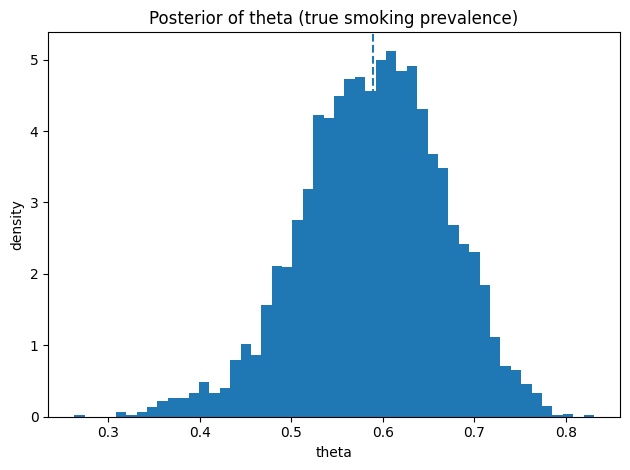

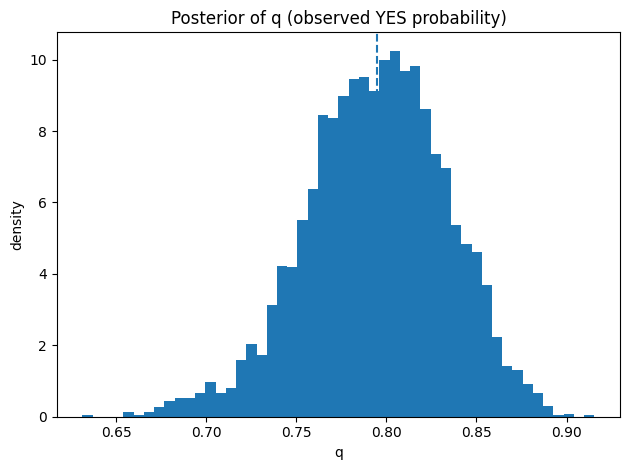

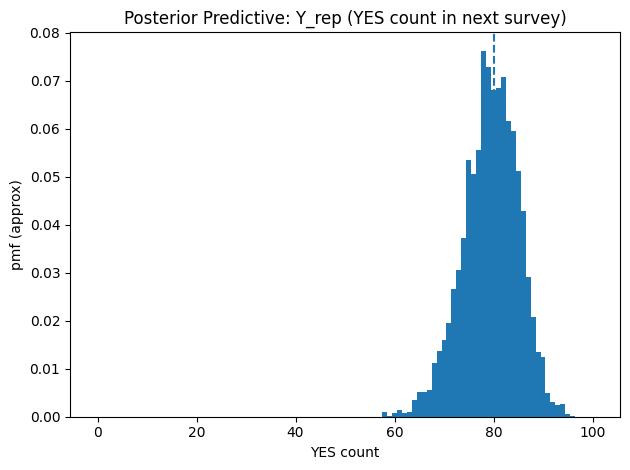

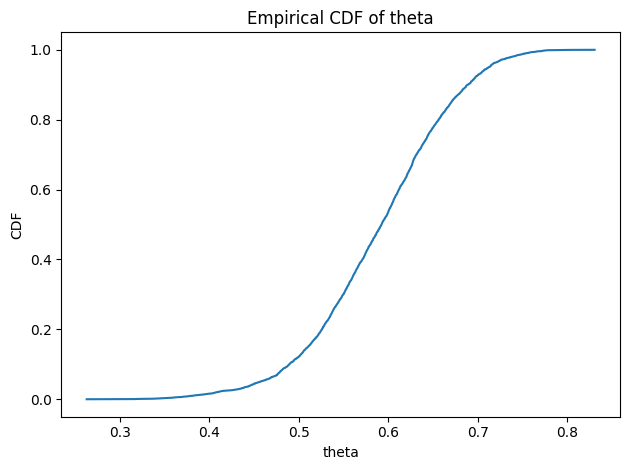

In [14]:

import matplotlib.pyplot as plt

# (A) Posterior of theta
plt.figure()
plt.hist(theta, bins=50, density=True)
plt.axvline(theta_mean, linestyle='--')
plt.title("Posterior of theta (true smoking prevalence)")
plt.xlabel("theta")
plt.ylabel("density")
plt.tight_layout()
plt.show()

# (B) Posterior of q
plt.figure()
plt.hist(q, bins=50, density=True)
plt.axvline(np.mean(q), linestyle='--')
plt.title("Posterior of q (observed YES probability)")
plt.xlabel("q")
plt.ylabel("density")
plt.tight_layout()
plt.show()

# (C) Posterior predictive of y_rep
plt.figure()
plt.hist(y_rep, bins=range(0, N+2), align='left', density=True)
plt.axvline(y_yes, linestyle='--')
plt.title("Posterior Predictive: Y_rep (YES count in next survey)")
plt.xlabel("YES count")
plt.ylabel("pmf (approx)")
plt.tight_layout()
plt.show()

# (D) ECDF of theta
theta_sorted = np.sort(theta)
cdf = np.linspace(0, 1, len(theta_sorted))
plt.figure()
plt.plot(theta_sorted, cdf)
plt.title("Empirical CDF of theta")
plt.xlabel("theta")
plt.ylabel("CDF")
plt.tight_layout()
plt.show()


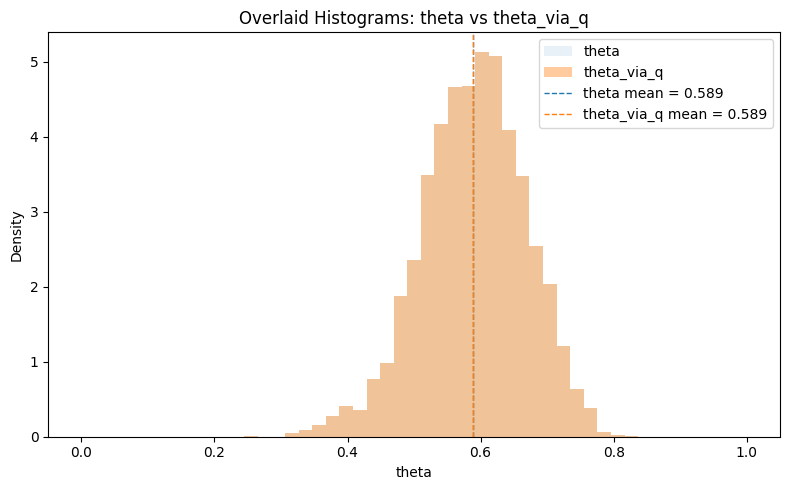

In [16]:
plt.figure(figsize=(8, 5))
bins = np.linspace(0, 1, 50)

plt.hist(theta, bins=bins, density=True, alpha=0.1, color='C0', label='theta')
plt.hist(theta_via_q, bins=bins, density=True, alpha=0.4, color='C1', label='theta_via_q')

plt.axvline(np.mean(theta), color='C0', linestyle='--', linewidth=1, label=f"theta mean = {np.mean(theta):.3f}")
plt.axvline(np.mean(theta_via_q), color='C1', linestyle='--', linewidth=1, label=f"theta_via_q mean = {np.mean(theta_via_q):.3f}")

plt.title("Overlaid Histograms: theta vs theta_via_q")
plt.xlabel("theta")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

(array([   4.,   32.,   82.,  288.,  747., 1069., 1039.,  579.,  149.,
          11.]),
 array([0.26267552, 0.31949895, 0.37632239, 0.43314582, 0.48996925,
        0.54679269, 0.60361612, 0.66043955, 0.71726298, 0.77408642,
        0.83090985]),
 <BarContainer object of 10 artists>)

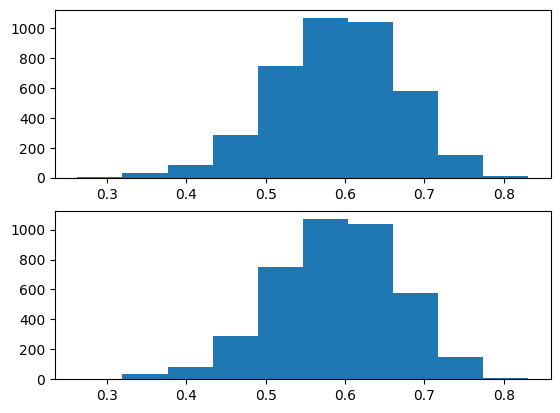

In [18]:
fig, axes = plt.subplots(2,1)
axes[0].hist(theta)
axes[1].hist(theta_via_q)


## 6. Notes & Extensions

- **Misclassification**: Add small-error probabilities for forced/true responses to model careless errors.  
- **Hierarchical Groups**: If multiple cohorts/years, model \(\theta_g\) with a hierarchical Beta prior.  
- **Different Randomizers**: If \(p\neq 0.5\) or rules are asymmetric, replace `p_forced` accordingly.

Feel free to modify priors (`alpha`, `beta`) to reflect domain knowledge.


해설 및 체크 포인트

- 식: $ q = p + (1 - p) \theta$ 
- 사전 분포: $\theta \sim Beta(\alpha, beta)$
- 사후요약: $\theta$의 평균, 95% Credible Interval 보고
- 시각화
    - $p(\theta|data)$
    - $p(q|data)$
    - posterior predictive $y$
    - ecdf($\theta|data$)

모델 확장 아이디어

- 오차/응답불성실: 강제 YES 인데 No를 말하거나 하는 소규모 오차를 포함한 잘못 분류 (misclassification) 모형
- 복수 코호트/연도 비교: 집단별 연도별 $\theta_g$에 대한 계층적 베타 사전분포
- 다중 랜덤화 장치: $p=0.5$가 아니거나 YES/NO 강제 규틱이 비대칭인 설계일 때 일반화


### What is the purpose/role of theta_via_q?

theta_vai_q is a derived (redundant) quantity that's included in the Stan `generated quantities` block for interpretability and validation.

1. Relationship between theta and q
    In the model
    $$
        q = p_{forced} + (1 - p_{forced}) \theta 
    $$
    This maps the true prevalence (theta) to the observed probability of answering YES (q)

2. Inversion
    You can algebraically invert this mapping:
    $$
        \theta = \frac{q - p_{forced}}{1 - p_{forced}}
    $$
    This inverted value is what we call    `theta_via_q`

3. Purpose of `theta_via_q`
    - Sanity check:
        - Ensures that the trasformation between q and theta behaves as expected.
        - When sampling, the posterior draws of `theta` and the reconstructed `theta_via_q` should almost coinside (minor numerical noise only)

    - Interpretability in generated quantities:
        If you are working with `q` (the probability of answering YES) instead of `theta`, this back-transformation lets you interpret the posterior in terms of the true prevalence again.

    - Safety clamping: to ensure it always stays within [0,1] even if numeric jitter pushes `q` slightly outside

4. Practical use
    In your analysis, you can
        - Compare  `theta` and `theta_via_q` posterior histograms to verify correctness.
        - Drop `theta_via_q` entirely once you trust your model - it's optional.

* It is there for diagnoistic transparency, not because the model needs it.
